In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

/home/shawn/miniconda3/envs/fast/lib/python3.9/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [2]:
#hide
from fastbook import *

# 图片分类

现在您已了解深度学习是什么、它的用途以及如何创建和部署模型，是时候让我们更深入地学习了！在一个理想的世界中，深度学习从业者不必了解事物在幕后如何工作的每一个细节……但到目前为止，我们还没有生活在一个理想的世界中。事实是，要使您的模型真正起作用，并且可靠地起作用，您必须正确处理许多细节，并且必须检查许多细节。这个过程需要能够在训练和预测时查看神经网络内部，发现可能的问题，并知道如何解决它们。

因此，从本书的此处开始，我们将深入探讨深度学习的机制。计算机视觉模型、NLP模型、表格模型等的架构是怎样的？您如何创建满足特定领域需求的架构？您如何从培训过程中获得最佳结果？你如何让事情变得更快？随着数据集的变化，你必须改变什么？

我们将从重复我们在第一章中看到的相同的基本应用程序开始，但我们要做两件事：

- 让他们变得更好。
- 将它们应用于更广泛类型的数据。

为了完成这两件事，我们将不得不学习深度学习难题的所有部分。这包括不同类型的层、正则化方法、优化器、如何将层组合到架构中、标记技术等等。不过，我们不只是要把所有这些东西都扔给你；我们将根据需要逐步引入它们，以解决与我们正在进行的项目相关的实际问题。

## 从猫狗到宠物品种

在我们的第一个模型中，我们学习了如何对狗和猫进行分类。就在几年前，这还被认为是一项非常具有挑战性的任务——但在今天，这太容易了！我们将无法向您展示具有此问题的训练模型的细微差别，因为我们得到了近乎完美的结果而无需担心任何细节。但事实证明，同一个数据集还允许我们处理一个更具挑战性的问题：弄清楚每张图片中显示的是什么品种的宠物。

在 <<chapter_intro>> 中，我们将应用程序呈现为已解决的问题。但这不是现实生活中的事情。我们从一些我们一无所知的数据集开始。然后我们必须弄清楚它是如何组合在一起的，如何从中提取我们需要的数据，以及这些数据是什么样子的。在本书的其余部分，我们将向您展示如何在实践中解决这些问题，包括了解您正在使用的数据和测试您的建模所需的所有中间步骤。

我们已经下载了 Pet 数据集，我们可以使用与 <<chapter_intro>> 中相同的代码获取该数据集的路径：

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

现在，如果我们要了解如何从每张图像中提取每只宠物的品种，我们将需要了解这些数据的布局方式。数据布局的这些细节是深度学习难题的重要组成部分。数据通常以以下两种方式之一提供：

- 代表数据项的单个文件，例如文本文档或图像，可能组织到文件夹中或文件名代表有关这些项目的信息
- 数据表，例如 CSV 格式，其中每一行都是一个项目，其中可能包括文件名，提供表中数据与其他格式数据（例如文本文档和图像）之间的连接

这些规则也有例外——特别是在基因组学等领域，那里可以有二进制数据库格式甚至网络流——但总的来说，您将使用的绝大多数数据集将使用这两种格式的某种组合。

要查看数据集中的内容，我们可以使用 ls 方法：

In [4]:
path.ls()

(#2) [Path('/home/shawn/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/shawn/.fastai/data/oxford-iiit-pet/images')]

我们可以看到这个数据集为我们提供了 *images* 和 *annotations* 目录。数据集的 [网站](https://www.robots.ox.ac.uk/~vgg/data/pets/) 告诉我们 *annotations* 目录包含有关宠物所在位置的信息比他们是什么。在本章中，我们将进行分类，而不是定位，也就是说我们关心宠物是什么，而不是它们在哪里。因此，我们暂时忽略 *annotations* 目录。那么，让我们看看 *images* 目录：

In [5]:
(path/"images").ls()

(#7393) [Path('/home/shawn/.fastai/data/oxford-iiit-pet/images/pomeranian_54.jpg'),Path('/home/shawn/.fastai/data/oxford-iiit-pet/images/Persian_95.jpg'),Path('/home/shawn/.fastai/data/oxford-iiit-pet/images/keeshond_61.jpg'),Path('/home/shawn/.fastai/data/oxford-iiit-pet/images/keeshond_136.jpg'),Path('/home/shawn/.fastai/data/oxford-iiit-pet/images/Maine_Coon_46.jpg'),Path('/home/shawn/.fastai/data/oxford-iiit-pet/images/saint_bernard_134.jpg'),Path('/home/shawn/.fastai/data/oxford-iiit-pet/images/saint_bernard_189.jpg'),Path('/home/shawn/.fastai/data/oxford-iiit-pet/images/shiba_inu_52.jpg'),Path('/home/shawn/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_111.jpg'),Path('/home/shawn/.fastai/data/oxford-iiit-pet/images/basset_hound_36.jpg')...]

fastai 中返回集合的大多数函数和方法都使用一个名为“L”的类。 `L` 可以被认为是普通 Python `list` 类型的增强版本，增加了常用操作的便利性。例如，当我们在笔记本中显示此类的对象时，它会以此处显示的格式出现。首先显示的是集合中的项目数，前缀为“#”。您还会在前面的输出中看到该列表以省略号作为后缀。这意味着只显示前几个项目——这是一件好事，因为我们不想在屏幕上显示超过 7,000 个文件名！

通过检查这些文件名，我们可以看到它们的结构。每个文件名都包含宠物品种，然后是下划线 (`_`)、数字，最后是文件扩展名。我们需要创建一段代码，从单个“路径”中提取品种。 Jupyter notebooks 让这一切变得简单，因为我们可以逐渐构建一些有用的东西，然后将它用于整个数据集。我们必须小心，不要在这一点上做出太多假设。例如，如果你仔细看，你可能会注意到一些宠物品种包含多个单词，所以我们不能简单地在我们找到的第一个 `_` 字符处中断。为了让我们测试我们的代码，让我们选择这些文件名之一：

In [6]:
fname=(path/'images').ls()[0]

像这样从字符串中提取信息的最强大、最灵活的方法是使用*正则表达式*，也称为*正则表达式*。正则表达式是一个特殊的字符串，用正则表达式语言编写，它指定了一个通用规则，用于确定另一个字符串是否通过测试（即“匹配”正则表达式），也可能用于提取特定部分或部分那个其他字符串。

在这种情况下，我们需要一个从文件名中提取宠物品种的正则表达式。

我们没有足够的空间在这里为您提供完整的正则表达式教程，但是网上有很多优秀的教程，我们知道你们中的许多人已经熟悉这个出色的工具。如果你不是，那完全没问题——这是你改正的好机会！我们发现正则表达式是我们编程工具包中最有用的工具之一，我们的许多学生告诉我们，这是他们最想学习的东西之一。因此，现在前往 Google 并搜索“正则表达式教程”，然后在仔细浏览后返回此处。 [本书的网站](https://book.fast.ai/) 还提供了我们最喜欢的列表。

> a：正则表达式不仅非常方便，而且还有有趣的根源。它们是“常规”的，因为它们最初是“常规”语言的示例，是乔姆斯基层次结构中最低的梯级，这是由语言学家诺姆乔姆斯基开发的语法分类，他还撰写了_Syntactic Structures_，这是搜索的开创性工作用于人类语言的形式语法。这就是计算的魅力之一：可能你每天拿的锤子实际上来自宇宙飞船。

当您编写正则表达式时，最好的开始方式是首先针对一个示例进行尝试。让我们使用 `findall` 方法尝试对 `fname` 对象的文件名使用正则表达式：

In [7]:
fname.name

'pomeranian_54.jpg'

In [8]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['pomeranian']

这个正则表达式会去掉最后一个下划线字符之前的所有字符，只要后续字符是数字，然后是 JPEG 文件扩展名。

现在我们确认正则表达式适用于该示例，让我们用它来标记整个数据集。 fastai 带有许多类来帮助标记。要使用正则表达式进行标记，我们可以使用 RegexLabeller 类。在这个例子中，我们使用我们在 <<chapter_production>> 中看到的数据块 API（事实上，我们几乎总是使用数据块 API——它比我们在 <<chapter_intro>> 中看到的简单工厂方法灵活得多）：

In [9]:

# 网上提到该设置可能有其他风险
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

我们以前从未见过的这个“DataBlock”调用的一个重要部分是在这两行中：

```python
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)
```
这些行实现了我们称之为 *presizing* 的 fastai 数据增强策略。 Presizing 是一种特殊的图像增强方法，旨在最大限度地减少数据破坏，同时保持良好的性能。

## 预调整

我们需要使图像具有相同的尺寸，以便它们可以组合成张量，以传递给GPU。我们还希望尽量减少所执行的不同增强计算的数量。性能要求表明，我们应该在可能的情况下将增强变换组合成较少的变换（以减少计算和有损操作的数量），并将图像转换为统一的尺寸（以在GPU上更高效地处理）。

挑战在于，如果在调整大小至增强尺寸之后执行各种常见的数据增强变换，可能会引入虚假的空白区域，降低数据质量，或者两者兼而有之。例如，将图像旋转45度会在新边界的角区域填充空白，这不会给模型提供任何信息。许多旋转和缩放操作将需要插值来创建像素。这些插值像素是从原始图像数据派生而来的，但质量较低。

为了解决这些挑战，预调整采用了两种策略，如下所示：

1. 将图像调整为相对较大的尺寸，即明显大于目标训练尺寸。
2. 将所有常见的增强操作（包括调整大小到最终目标尺寸）组合为一个操作，并且在处理结束时仅在GPU上执行一次组合操作，而不是逐个执行操作并进行多次插值。

第一步是调整大小，创建足够大的图像，使其内部区域有足够的余地进行进一步的增强变换，而不会创建空白区域。此变换通过使用较大的裁剪尺寸将图像调整为正方形来实现。在训练集上，裁剪区域是随机选择的，并且裁剪的大小被选为覆盖图像的整个宽度或高度，以较小者为准。

在第二步中，使用GPU进行所有的数据增强，并且所有可能破坏数据的操作都一起执行，在最后进行单次插值。

![image](https://github.com/fastai/fastbook/blob/master/images/att_00060.png?raw=1)

此图显示了两个步骤：

1. *Crop full width or height*：这是在 `item_tfms` 中，因此它会在复制到 GPU 之前应用于每个单独的图像。它用于确保所有图像的大小相同。在训练集上，裁剪区域是随机选择的。在验证集上，始终选择图像的中心方块。
2. *Random crop and augment*：这是在 `batch_tfms` 中，所以它在 GPU 上一次应用于一个批次，这意味着它很快。在验证集上，这里只调整到模型需要的最终大小。在训练集上，首先进行随机裁剪和任何其他增强。

为了在 fastai 中实现这个过程，你使用 `Resize` 作为一个大尺寸的项目转换，使用 `RandomResizedCrop` 作为一个小尺寸的批量转换。如果您在 `aug_transforms` 函数中包含 `min_scale` 参数，则会为您添加 `RandomResizedCrop`，就像在上一节的 `DataBlock` 调用中所做的那样。或者，您可以使用 `pad` 或 `squish` 代替 `crop`（默认）来进行初始 `Resize`。

<<interpolations>> 显示了经过缩放、插值、旋转然后再次插值（这是所有其他深度学习库使用的方法）的图像（如右侧所示）与经过缩放和旋转的图像之间的差异作为一个操作，然后在左侧仅插值一次（fastai 方法），如左图所示。

<AxesSubplot:>

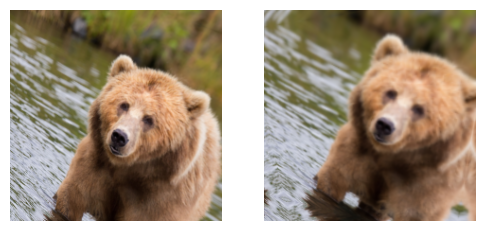

In [11]:
# 定义DataBlock
dblock1 = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_y=parent_label,
    item_tfms=Resize(460) # 调整图像大小为460
)

# 运行之前
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8) # 创建数据加载器
dls1.train.get_idxs = lambda: Inf.ones # 设置训练索引
x, y = dls1.valid.one_batch() # 获取一个批次的验证数据

_, axs = subplots(1, 2) # 创建子图

# 传统方法
x1 = TensorImage(x.clone()) # 克隆输入数据
x1 = x1.affine_coord(sz=224) # 仿射坐标变换
x1 = x1.rotate(draw=30, p=1.) # 旋转图像
x1 = x1.zoom(draw=1.2, p=1.) # 缩放图像
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.) # 扭曲图像

# 设置增强变换
tfms = setup_aug_tfms([
    Rotate(draw=30, p=1, size=224), # 旋转
    Zoom(draw=1.2, p=1., size=224), # 缩放
    Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224) # 扭曲
])
x = Pipeline(tfms)(x) # 应用增强变换

# 展示图像
TensorImage(x[0]).show(ctx=axs[0]) # 显示增强后的图像
TensorImage(x1[0]).show(ctx=axs[1]) # 显示传统方法处理后的图像


您可以看到右侧的图像不太清晰，左下角有反射填充伪像；另外，左上角的草已经完全消失了。我们发现在实践中使用预调整显着提高了模型的准确性，并且通常也会导致加速。

fastai 库还提供了在训练模型之前检查数据外观的简单方法，这是非常重要的一步。我们接下来会看看那些。

### 检查和调试数据块

我们永远不能假设我们的代码运行完美。编写 `DataBlock` 就像编写蓝图一样。如果您的代码中某处存在语法错误，您将收到一条错误消息，但您无法保证您的模板将按您的预期在您的数据源上运行。因此，在训练模型之前，您应该始终检查您的数据。您可以使用 `show_batch` 方法执行此操作：

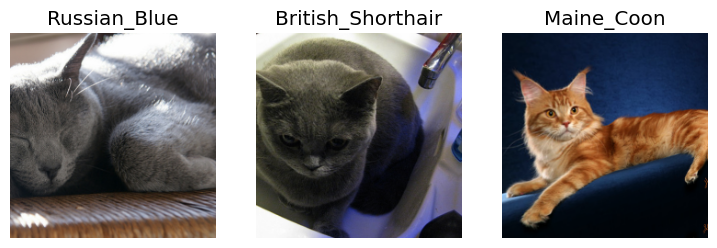

In [12]:
dls.show_batch(nrows=1, ncols=3)

查看每张图片，检查每张图片是否都贴有该品种宠物的正确标签。通常，数据科学家处理的数据可能不像领域专家那样熟悉：例如，我实际上不知道这些宠物品种是什么。由于我不是宠物品种方面的专家，此时我会使用 Google 图像来搜索其中的一些品种，并确保图像看起来与我在此输出中看到的相似。

如果您在构建“DataBlock”时犯了错误，很可能在此步骤之前看不到它。要对此进行调试，我们鼓励您使用 `summary` 方法。它将尝试从您提供的源创建一个批次，其中包含很多细节。另外，如果它失败了，你会准确地看到错误发生在哪一点，图书馆会尽力给你一些帮助。例如，一个常见的错误是忘记使用“调整大小”转换，因此您最终会得到不同尺寸的图片并且无法对它们进行批处理。在这种情况下，摘要如下所示（请注意，自撰写本文以来，确切的文本可能已更改，但它会给你一个想法）：

In [17]:
pets1 = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(224)  # 添加Resize转换以确保所有图像具有相同的尺寸，编者加
)
pets1.summary(path/'images')


Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/shawn/.fastai/data/oxford-iiit-pet/images/Bombay_173.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=334x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/shawn/.fastai/data/oxford-iiit-pet/images/Bombay_173.jpg
    applying partial gives
      Bombay
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=334x500, TensorCategory(3))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item

您可以确切地看到我们是如何收集和拆分数据的，我们是如何从一个文件名变成一个 *sample*（元组 (image, category)），然后应用了哪些项目转换以及它如何无法整理一批中的那些样品（因为形状不同）。

一旦您认为您的数据看起来正确，我们通常建议下一步应该使用它来训练一个简单的模型。我们经常看到人们将实际模型的训练推迟太久。结果，他们实际上并不知道他们的基线结果是什么样子的。也许您的问题不需要大量花哨的特定领域工程。或者数据似乎根本无法训练模型。这些是您想尽快知道的事情。对于这个初始测试，我们将使用我们在 <<chapter_intro>> 中使用的相同简单模型：

In [18]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/home/shawn/miniconda3/envs/fast/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/shawn/miniconda3/envs/fast/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.503705,0.315226,0.104195,04:05


epoch,train_loss,valid_loss,error_rate,time
0,0.522612,0.250224,0.084574,05:38
1,0.314995,0.200344,0.066982,05:41


正如我们之前简要讨论过的，拟合模型时显示的表格向我们展示了每个训练时期后的结果。请记住，一个时期是一次完整地遍历数据中的所有图像。显示的列是训练集项目的平均损失、验证集的损失以及我们要求的任何指标——在本例中为错误率。

请记住，*loss* 是我们决定用来优化模型参数的任何函数。但是我们实际上并没有告诉 fastai 我们想要使用什么损失函数。那它在做什么呢？ fastai 通常会尝试根据您使用的数据类型和模型选择合适的损失函数。在这种情况下，我们有图像数据和分类结果，因此 fastai 将默认使用*交叉熵损失*。

## 交叉熵损失

*交叉熵损失* 是一种类似于我们在上一章中使用的损失函数，但（正如我们将看到的）有两个好处：

- 即使我们的因变量有两个以上的类别，它也能起作用。
- 它导致更快和更可靠的训练。

为了理解交叉熵损失如何适用于具有两个以上类别的因变量，我们首先必须了解损失函数看到的实际数据和激活是什么样子的。

### 查看激活和标签

让我们来看看我们模型的激活。要从我们的 DataLoaders 中实际获取一批真实数据，我们可以使用 one_batch 方法：

In [19]:
x,y = dls.one_batch()

In [21]:
x.shape,y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

如您所见，这将以小批量形式返回因变量和自变量。让我们看看我们的因变量中实际包含了什么：

In [23]:
y

TensorCategory([13,  6, 26,  0, 28, 11, 22, 14, 34,  7, 29, 20,  4, 36, 15,  2, 16, 21, 24, 14,  0, 12,  9, 18, 27,  3, 35,  2, 13,  0, 11, 31,  0, 22, 24, 31, 28, 36, 27,  8, 12, 10, 18, 31, 20, 13,
                 0, 25, 12, 13,  8, 22, 27, 10, 18,  6, 14, 25, 25, 25, 13, 16,  9,  7])

我们的批量大小是 64，所以我们在这个张量中有 64 行。每行都是 0 到 36 之间的单个整数，代表我们的 37 种可能的宠物品种。我们可以使用 `Learner.get_preds` 查看预测（即神经网络最后一层的激活）。此函数采用数据集索引（0 表示训练，1 表示有效）或批次迭代器。因此，我们可以将一个简单的列表与我们的批次一起传递给它，以获得我们的预测。它默认返回预测和目标，但由于我们已经有了目标，我们可以通过分配给特殊变量 `_` 来有效地忽略它们：

In [25]:
preds,_=learn.get_preds(dl=[(x,y)])
preds.shape,_.shape

(torch.Size([64, 37]), torch.Size([64]))

实际的预测结果是介于0和1之间的37个概率值，这些概率值总和为1：

In [26]:
len(preds[0]), preds[0].sum()

(37, tensor(1.))

为了将我们模型的激活转换成这样的预测，我们使用了一种叫做 *softmax* 激活函数的东西。

### Softmax

在我们的分类模型中，我们在最后一层使用 softmax 激活函数来确保激活值都在 0 和 1 之间，并且它们之和为 1。

Softmax 类似于我们之前看到的 sigmoid 函数。作为提醒，sigmoid看起来像这样：

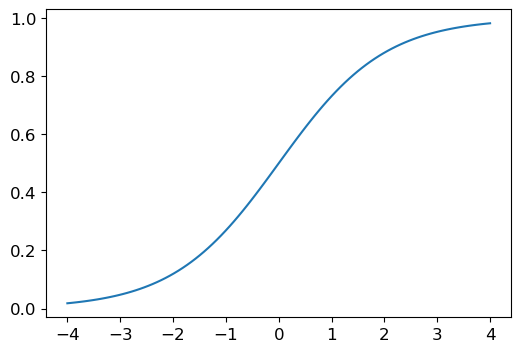

In [27]:
plot_function(torch.sigmoid, min=-4,max=4)

我们可以将此函数应用于神经网络的单列激活，并返回一列介于 0 和 1 之间的数字，因此它对我们的最后一层来说是一个非常有用的激活函数。

现在想想如果我们想在我们的目标中有更多类别（比如我们的 37 种宠物品种）会发生什么。这意味着我们需要的激活不仅仅是一个列：我们需要一个激活*每个类别*。例如，我们可以创建一个预测 3s 和 7s 的神经网络，返回两个激活，每个类别一个——这将是创建更通用方法的良好开端。对于这个例子，我们只使用一些标准差为 2 的随机数（因此我们将 randn 乘以 2），假设我们有 6 张图像和 2 个可能的类别（其中第一列代表 3s，第二列代表 7s）：

In [28]:
torch.random.manual_seed(42)

In [44]:
acts=torch.randn(6,2)*2
acts

tensor([[ 0.5630,  0.1123],
        [ 1.0454, -0.4767],
        [-0.0998,  1.0527],
        [-0.0170,  1.4581],
        [ 0.2663,  1.7280],
        [-2.0313, -1.7775]])

我们不能直接取它的 sigmoid，因为我们没有得到加起来为 1 的行（即，我们希望是 3 的概率加上是 7 的概率加起来等于 1）：

在 <<chapter_mnist_basics>> 中，我们的神经网络为每个图像创建了一个激活，我们通过 `sigmoid` 函数传递了该激活。单个激活表示模型对输入为 3 的置信度。二元问题是分类问题的特例，因为目标可以被视为单个布尔值，就像我们在“mnist_loss”中所做的那样。但是二元问题也可以在具有任意数量类别的更一般的分类器组的上下文中考虑：在这种情况下，我们恰好有两个类别。正如我们在熊分类器中看到的那样，我们的神经网络将为每个类别返回一个激活。

那么在二元情况下，这些激活究竟意味着什么？一对激活简单地表示输入是 3 还是 7 的*相对*置信度。总体值，无论它们是高还是低，都不重要——重要的是哪个更高，高多少。

我们希望，因为这只是表示相同问题的另一种方式，所以我们可以直接在神经网络的双激活版本上使用“sigmoid”。我们确实可以！我们可以只取神经网络激活之间的*差异*，因为这反映了我们对输入是 3 比 7 更有把握，然后取其 sigmoid：

In [45]:
 (acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6108, 0.8209, 0.2400, 0.1862, 0.1882, 0.4369])

第二列（它是 7 的概率）将只是从 1 中减去的那个值。现在，我们需要一种方法来完成所有这一切，该方法也适用于多于两列。事实证明，这个名为“softmax”的函数正是：

``` python
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```

> 行话：指数函数 (exp)：字面定义为 `e**x`，其中 `e` 是一个约等于 2.718 的特殊数字。它是自然对数函数的倒数。请注意，`exp` 始终为正，并且它_非常_ 迅速增加！

让我们检查 `softmax` 是否返回与第一列的 `sigmoid` 相同的值，以及从 1 中减去第二列的那些值：

In [47]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6108, 0.3892],
        [0.8209, 0.1791],
        [0.2400, 0.7600],
        [0.1862, 0.8138],
        [0.1882, 0.8118],
        [0.4369, 0.5631]])

`softmax` 是 `sigmoid` 的多类别等价物——只要我们有两个以上的类别，并且类别的概率必须加起来为 1，我们就必须使用它，即使只有两个类别，我们也经常使用它，只是为了让事情更加一致。我们可以创建其他函数，这些函数具有所有激活都在 0 和 1 之间且总和为 1 的属性；然而，没有其他函数与 sigmoid 函数具有相同的关系，我们已经看到它是平滑和对称的。此外，我们很快就会看到 softmax 函数与我们将在下一节中看到的损失函数协同工作。

如果我们有三个输出激活，例如在我们的熊分类器中，计算单个熊图像的 softmax 将类似于 <<bear_softmax>>。

![image](https://github.com/fastai/fastbook/blob/master/images/att_00062.png?raw=1)

这个函数在实践中有什么作用？取指数确保我们所有的数字都是正数，然后除以总和确保我们将得到一堆加起来为 1 的数字。指数还有一个很好的属性：如果我们的激活中的一个数字 `x ` 比其他的稍大，指数会放大它（因为它增长，好吧......呈指数增长），这意味着在 softmax 中，该数字将更接近 1。

直觉上，softmax 函数*真的*想要从其他类别中挑选一个类别，因此当我们知道每张图片都有明确的标签时，它非常适合训练分类器。 （请注意，它在推理期间可能不太理想，因为您可能希望您的模型有时会告诉您它无法识别它在训练期间看到的任何类，并且不会选择一个类，因为它的激活分数稍高. 在这种情况下，使用多个二进制输出列训练模型可能会更好，每个列都使用 sigmoid 激活。）

Softmax 是交叉熵损失的第一部分——第二部分是对数似然。

### 对数似然

当我们在上一章计算 MNIST 示例的损失时，我们使用了：

```python
def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()
```

正如我们从 sigmoid 转移到 softmax 一样，我们需要扩展损失函数以使其不仅仅适用于二元分类——它需要能够对任意数量的类别进行分类（在本例中，我们有 37 个类别）。在 softmax 之后，我们的激活值介于 0 和 1 之间，并且预测批次中每一行的总和为 1。我们的目标是 0 到 36 之间的整数。此外，交叉熵损失泛化了我们的二元分类损失，并允许每个示例有多个正确标签（这称为多标签分类，我们将在第 6 章中讨论）。

在二进制情况下，我们使用 `torch.where` 在 `inputs` 和 `1-inputs` 之间进行选择。当我们将二元分类视为具有两个类别的一般分类问题时，它实际上变得更加容易，因为（正如我们在上一节中看到的）我们现在有两列，包含等效的“inputs”和“1-inputs” .由于每个示例只有一个正确的标签，我们需要做的就是选择适当的列（而不是乘以多个概率）。让我们尝试在 PyTorch 中实现它。对于我们的合成 3 和 7 示例，假设这些是我们的标签：

In [49]:
targ = tensor([0,1,0,1,1,0])

这些是 softmax 激活：

In [50]:
sm_acts

tensor([[0.6108, 0.3892],
        [0.8209, 0.1791],
        [0.2400, 0.7600],
        [0.1862, 0.8138],
        [0.1882, 0.8118],
        [0.4369, 0.5631]])

然后对于 `targ` 的每一项，我们可以使用它来使用张量索引选择 `sm_acts` 的适当列，如下所示：

In [51]:
idx=range(6)
sm_acts[idx, targ]

tensor([0.6108, 0.1791, 0.2400, 0.8138, 0.8118, 0.4369])

为了准确了解此处发生的情况，让我们将所有列放在一个表中。在这里，前两列是我们的激活，然后是目标和行索引。我们在下面解释最后一列“结果”：

In [72]:
from IPython.display import HTML

def display_predictions(sm_acts, targ, idx):
    column_names = ['3', '7']
    df = pd.DataFrame(sm_acts, columns=column_names).assign(targ=targ, idx=idx)
    df['result'] = sm_acts[range(6), targ]

    html = df.to_html(index=False)
    display(HTML(html))

# 使用示例
display_predictions(sm_acts, targ, idx)


3,7,targ,idx,result
0.610808,0.389191,0,0,0.610808
0.820854,0.179146,1,1,0.179146
0.240036,0.759964,0,2,0.240036
0.186166,0.813834,1,3,0.813834
0.188212,0.811788,1,4,0.811788
0.436876,0.563124,0,5,0.436876


查看此表，您可以看到可以通过将 `targ` 和 `idx` 列作为包含 `3` 和 `7` 列的双列矩阵的索引来计算 `result` 列。这就是 sm_acts[idx, targ] 的实际作用。这里真正有趣的是，这实际上与两个以上的列一样有效。要看到这一点，请考虑如果我们为每个数字（0 到 9）添加一个激活列，然后 `targ` 包含一个从 0 到 9 的数字会发生什么。

PyTorch 提供了一个与 sm_acts[range(n), targ] 完全相同的函数（除了它取负数，因为之后应用日志时，我们将得到负数），称为 nll_loss`（*NLL* 代表*负对数似然*）：

In [73]:
-sm_acts[idx, targ]

tensor([-0.6108, -0.1791, -0.2400, -0.8138, -0.8118, -0.4369])

尽管它的名字如此，但这个 PyTorch 函数并不获取日志。我们将在下一节中了解原因，但首先，让我们了解为什么取对数有用。

> 警告：名字容易混淆，注意：`nll_loss` 中的 nll 代表“负对数似然”，但它实际上根本不取对数！它假设您_已经_记录了日志。 PyTorch 有一个名为“log_softmax”的函数，它以快速准确的方式组合了“log”和“softmax”。 `nll_loss` 被设计为在 `log_softmax` 之后使用。

#### 获取日志

回想一下，交叉熵损失可能涉及许多数字的乘法。将大量负数相乘可能会导致计算机出现[数值下溢](https://en.wikipedia.org/wiki/Arithmetic_underflow) 等问题。因此，我们希望将这些概率转换为更大的值，以便我们可以对它们进行数学运算。有一个数学函数可以执行此操作：*对数*（可作为 `torch.log` 使用）。它没有为小于 0 的数字定义，在 0 和 1 之间看起来像这样：

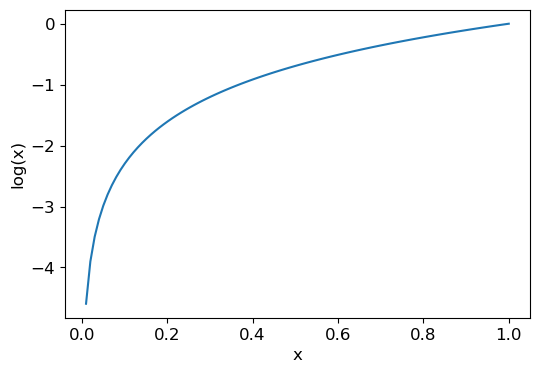

In [74]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

此外，我们希望确保我们的模型能够检测到小数字之间的差异。例如，考虑 .01 和 .001 的概率。事实上，这些数字非常接近——但从另一种意义上说，0.01 的置信度是 0.001 的 10 倍。通过记录我们的概率，我们可以防止忽略这些重要的差异。

“对数”这个词你听过吗？对数函数具有以下等式：

$$
y = b^a \\
a = \log{y}{b}
$$

在这种情况下，我们假设`log(y, b)`返回以b为底y的对数。然而，PyTorch实际上并没有按照这种方式定义`log`：Python中的`log`使用特殊数字`e`（约为2.718...）作为底数，也就是`ln`。

也许对数这个概念在过去20年里你可能没有想过。但对数是深度学习中非常关键的数学概念，所以现在是恰好复习一下的好时机。关于对数的关键是下面这个关系：
$$
    \ln({a \times b}) = \ln{a} + \ln{b}
$$
当我们看到这个等式时，它看起来有点无聊；但是想一想它的实际意义。它意味着当基础信号以指数或乘法方式增长时，对数会线性增长。这在地震严重程度的里氏震级和噪音水平的分贝（dB）刻度中经常被使用。在金融图表中，也经常使用对数来更清楚地显示复利增长率。计算机科学家喜欢使用对数，因为它意味着乘法（可以产生非常大和非常小的数字）可以被加法所替代，而加法对于计算机更容易处理。

注意到当一个数字接近零时，它的对数趋近于负无穷大。在我们的情况下，由于结果反映了正确标签的预测概率，我们希望损失函数在预测“好”（接近1）时返回较小的值，在预测“坏”（接近0）时返回较大的值。我们可以通过取负对数来实现这一点：

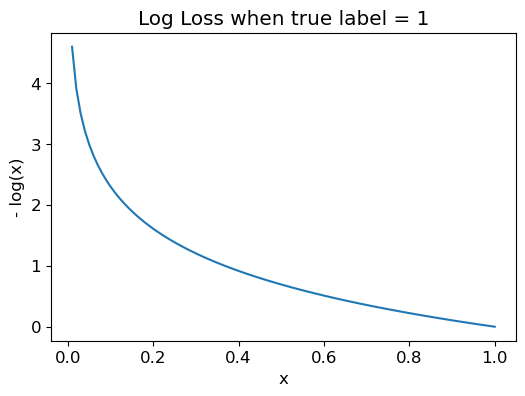

In [77]:
plot_function(
    lambda x: -torch.log(x), 
    min=0,
    max=1, 
    tx='x', 
    ty='- log(x)', 
    title = 'Log Loss when true label = 1'
)

> s: 不只是计算机科学家喜欢对数！在计算机出现之前，工程师和科学家使用一种称为“计算尺”的特殊尺子，通过对数相加来进行乘法运算。对数广泛用于物理学，用于乘以非常大或非常小的数字，以及许多其他领域。

让我们继续更新我们之前的表格，增加一列“loss”来反映这个损失函数：

In [91]:
from IPython.display import HTML

def display_predictions(sm_acts, targ, idx):
    column_names = ['3', '7']
    df = pd.DataFrame(sm_acts, columns=column_names).assign(targ=targ, idx=idx)
    df['result'] = sm_acts[range(6), targ]
    df['loss'] = -torch.log(tensor(df['result']))
    html = df.to_html(index=False)
    display(HTML(html))

display_predictions(sm_acts, targ, idx)

3,7,targ,idx,result,loss
0.610808,0.389191,0,0,0.610808,0.492972
0.820854,0.179146,1,1,0.179146,1.719556
0.240036,0.759964,0,2,0.240036,1.426965
0.186166,0.813834,1,3,0.813834,0.205999
0.188212,0.811788,1,4,0.811788,0.208516
0.436876,0.563124,0,5,0.436876,0.828107


请注意第二行和第三行的损失非常大，其中预测有把握但错误，或者换句话说，错误类别的概率很高。使用对数计算损失的一个好处是我们的损失函数会惩罚既有把握又错误的预测。这种惩罚在实践中效果很好，可以帮助进行更有效的模型训练。

> s：还有其他损失函数，例如 [focal loss](https://arxiv.org/pdf/1708.02002.pdf) 允许您使用参数控制此惩罚。我们不会在本书中讨论该损失函数。

我们正在计算包​​含正确标签的列的损失。因为每个示例只有一个“正确”答案，所以我们不需要考虑其他列，因为根据 softmax 的定义，它们加起来等于 1 减去正确标签对应的激活值。只要激活列总和为 1（如果我们使用 softmax，它们就会如此），那么我们就会有一个损失函数来显示我们对每个数字的预测有多好。因此，使正确标签的激活尽可能高必须意味着我们也在减少其余列的激活。

### 负对数似然

取概率的负对数的平均值（取表中“损失”列的平均值）得到*负对数似然*损失，这是交叉熵损失的另一个名称。回想一下，PyTorch 的“nll_loss”假定您已经获取了 softmax 的对数，因此它实际上不会为您计算对数。

当我们首先采用 softmax，然后采用对数似然时，该组合称为 *交叉熵损失*。在 PyTorch 中，这可以作为 `nn.CrossEntropyLoss` 使用（在实践中，它实际上执行 `log_softmax` 然后是 `nll_loss`）：

In [92]:
loss_func = nn.CrossEntropyLoss()

如您所见，这是一个类。实例化它会为您提供一个行为类似于函数的对象：

In [93]:
loss_func(acts, targ)

tensor(0.8137)

所有 PyTorch 损失函数都以两种形式提供，一种是上面显示的类，另一种是普通函数形式，可在“F”命名空间中使用：

In [94]:
F.cross_entropy(acts, targ)

tensor(0.8137)

任何一个都可以正常工作，并且可以在任何情况下使用。我们注意到大多数人倾向于使用 class 版本，并且在 PyTorch 的官方文档和示例中更常使用它，因此我们也倾向于使用它。

默认情况下，PyTorch 损失函数采用所有项目损失的平均值。您可以使用 `reduction='none'` 来禁用它：

In [95]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.4930, 1.7196, 1.4270, 0.2060, 0.2085, 0.8281])

您会注意到这些值与我们表中的“损失”列完全匹配。

> s：当我们考虑它的梯度时，出现了一个关于交叉熵损失的有趣特征。 `cross_entropy(a,b)` 的梯度就是 `softmax(a)-b`。由于 softmax(a) 只是模型的最终激活，这意味着梯度与预测和目标之间的差异成正比。这与回归中的均方误差相同（假设没有像 y_range 添加的最终激活函数），因为 (a-b)**2 的梯度为 2 *(a-b)`。因为梯度是线性的，这意味着我们不会看到梯度突然跳跃或呈指数增长，这应该会导致模型训练更顺畅。